<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"


# <center>Проект. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Финальный отчет

### <center> Цели и задачи проекта

<right>Цель: Идентификация пользователя интернета по посещенным веб-страницам
<right>Задачи, решаемые во время проекта:
 - Построение признаков по исходным данным, их предобработка и визуализация
 - Построение и оптимизация модели классификации на полученных признаках
 - Анализ построенной модели, построение выводов

### <center> Описание данных

<right>Исходный датасет представляет собой csv файл для каждого из пользователей, в котором есть 2 колонки: название посещенного сайта и время его посещения. Из сырых данных получены 2 датасета для классификации. В первом каждая строка представляла собой сессию из 10 сайтов и длиной не более 30 минут (в первичном анализе не использовалось условие 30 минут), в которую по столбцам записывались id посещенных страниц. Если пользователь посетил меньше, чем 10 сайтах за более чем 30 минут, то пустые столбцы заполнялись нулями. Второй датасет представляет из себя разреженную матрицу, в которой строки соответствуют сессиям из session_length сайтов, а столбцы – количеству посещений site_id в сессии. В обоих случаях использовались дополнительные признаки такие как, кол-во посещенных уникальных сайтов, время начала сессии, количество посещенных популярных сайтов в сессии

#### <right> Для финального проекта были предоставлены сырые данные, данные для тренировки и теста в виде первого датасета и словарь уникальных сайтов 
### <center> Начнем исследование с 10 пользователей из выборки.

Напишем функцию для получения первого датасета. Она принимает на вход: path_to_csv_files -  путь к сырым данным на компьютере, site_freq_path - путь к заранее составленному словарю сайтов (ключ - название сайта, значение - его id), feature_names - названия признаков, session_length - длина сессии, window_size - ширина скользящего окна между сессиями

## <right> Внимание! Графики можно посмотреть в html версии или при самостоятельном запуске всех ячеек

In [1]:
# ячейка для импорта библиотек, которые понадобятся для проекта
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import plotly
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# функция для открытия файлов pickle
def openpickle(filename):
    with (open(filename, 'rb')) as openfile:
        objects = pickle.load(openfile)
    return objects

In [3]:
def prepare_train_set(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    a = glob(path_to_csv_files)
    b = openpickle(site_freq_path)
    lines = []                           # массив, где хранятся строки
    otvety = []                          # массив меток
    y = 0
    for file in enumerate(a):
        data1 = pd.read_csv(file[1])     # считываем файл     
        site_list = list(data1.site)                           # создаем отдельно список сайтов пользователя
        time_list = list(pd.to_datetime(data1['timestamp']))   # и список времени посещения этих сайтов
        y += 1
        for i in range(0,len(site_list),window_size):
            line = list(np.zeros(session_length))              # создаем список сайтов в сессии
            time_diff = list(np.zeros(session_length-1))       # разница во времени между посещениями разных сайтов
            if (i+session_length) <= len(site_list):           # если в списке достаточно сайтов для заполнения сессии 
                for j in range(i, i+session_length):           # по всем сайтам из session_length      
                    id_site = b.get(site_list[j])              # получаем id сайта     
                    line[j%session_length] = id_site           # заносим id в строку     
                    # если это не последний сайт в сессии, то считаем время между разными сайтами
                    if j != i+session_length-1:
                        time_diff[j%session_length] = int((time_list[j+1]-time_list[j]).seconds)
                    # заносим в строку доп. признаки: длина сессииб кол-во уникальных сайтов,
                    # час и день недели начала сессии
                    another = [sum(time_diff),len(np.unique(line)), time_list[i].hour, time_list[i].weekday()]
            # аналогично, если сайтов не хватает на полную сессию. В незаполенных ячейках - 0.
            else:                                 
                for j in range(i, len(site_list)):
                    id_site = b.get(site_list[j])
                    line[j%session_length] = id_site
                    if j != (len(site_list)-1):
                        time_diff[j%session_length] = int((time_list[j+1]-time_list[j]).seconds)
                another = [sum(time_diff),len(np.unique(line))-1, time_list[i].hour, time_list[i].weekday()]
            # соединяем все в одну строку
            line.extend(time_diff)
            line.extend(another)
            line.extend([y])
            # добавляем эту строку к общему массиву сессий
            lines.append(line)
    matrica = pd.DataFrame(lines, columns = feature_names)
    return matrica

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'lab']
train_data_10users  = prepare_train_set('10users/*.csv', 'site_dic.pkl',feature_names=feature_names, session_length=10)

In [5]:
# посмотрим на получившиеся данные
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,lab
0,1,2735.0,2736.0,23.0,2736.0,2736.0,23.0,2736.0,156.0,2736.0,...,20.0,1.0,0.0,1.0,0.0,33.0,5,8,4,1
1,155,319.0,1049.0,979.0,2736.0,38.0,2742.0,17786.0,473.0,2612.0,...,0.0,1.0,3.0,3.0,8.0,284.0,10,8,4,1
2,2612,23.0,2612.0,2612.0,29.0,324.0,155.0,325.0,2060.0,2612.0,...,0.0,0.0,1.0,0.0,0.0,258.0,7,8,4,1
3,716,17787.0,716.0,2612.0,2612.0,2612.0,2612.0,2051.0,2738.0,2740.0,...,25.0,1.0,0.0,0.0,0.0,30.0,6,8,4,1
4,323,2612.0,29.0,17788.0,756.0,400.0,17789.0,17790.0,2011.0,17790.0,...,1.0,0.0,1.0,1.0,0.0,6.0,9,8,4,1


**Визуализируем и проанализируем построенные дополнительные признаки**

In [6]:
a = range(1,11)
fig = tools.make_subplots(rows=2, cols=5, subplot_titles=a)
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'lab')): 
    trace = go.Histogram(x = sub_df['session_timespan'], name=user, xbins=dict(start=0, end=200))
    fig.append_trace(trace, int(idx/5)+1, int(idx%5)+1)
    
fig['layout'].update(title=u'Гистограмма признака: длина сессии пользователя')
iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]    [ (1,4) x4,y4 ]    [ (1,5) x5,y5 ]  
[ (2,1) x6,y6 ]    [ (2,2) x7,y7 ]    [ (2,3) x8,y8 ]    [ (2,4) x9,y9 ]    [ (2,5) x10,y10 ]



**Видно, что по признаку можно разделить выборку, однако навряд ли такое разделение будет точным, так как многие гистограммы похожи**

In [7]:
fig = tools.make_subplots(rows=2, cols=5, subplot_titles=a)
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'lab')): 
    trace = go.Histogram(x = sub_df['#unique_sites'], name=user)
    fig.append_trace(trace, int(idx/5)+1, int(idx%5)+1)
    
fig['layout'].update(title=u'Гистограмма признака: количество уникальных сайтов в сессии')
iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]    [ (1,4) x4,y4 ]    [ (1,5) x5,y5 ]  
[ (2,1) x6,y6 ]    [ (2,2) x7,y7 ]    [ (2,3) x8,y8 ]    [ (2,4) x9,y9 ]    [ (2,5) x10,y10 ]



**По гистограммам видно, что пользователи хорошо разделяются по количеству уникальных сайтов в сессии. Этот признак будет присутствовать в конечной модели**

In [8]:
fig = tools.make_subplots(rows=2, cols=5, subplot_titles=a)
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'lab')): 
    trace = go.Histogram(x = sub_df['start_hour'], name=user, nbinsx=10)
    fig.append_trace(trace, int(idx/5)+1, int(idx%5)+1)
    
fig['layout'].update(title=u'Гистограмма признака: час начала сессии')
iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]    [ (1,4) x4,y4 ]    [ (1,5) x5,y5 ]  
[ (2,1) x6,y6 ]    [ (2,2) x7,y7 ]    [ (2,3) x8,y8 ]    [ (2,4) x9,y9 ]    [ (2,5) x10,y10 ]



**Различия между пользователями заметны, час начала сессии будем применять в финальной модели**

In [9]:
fig = tools.make_subplots(rows=2, cols=5, subplot_titles=a)
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'lab')): 
    trace = go.Histogram(x = sub_df['day_of_week'], name=user)
    fig.append_trace(trace, int(idx/5)+1, int(idx%5)+1)
    
fig['layout'].update(title=u'Гистограмма признака: день недели, в который началась сессия')
iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]    [ (1,4) x4,y4 ]    [ (1,5) x5,y5 ]  
[ (2,1) x6,y6 ]    [ (2,2) x7,y7 ]    [ (2,3) x8,y8 ]    [ (2,4) x9,y9 ]    [ (2,5) x10,y10 ]



**День недели хорошо разделяет пользователей, что видно из графиков**

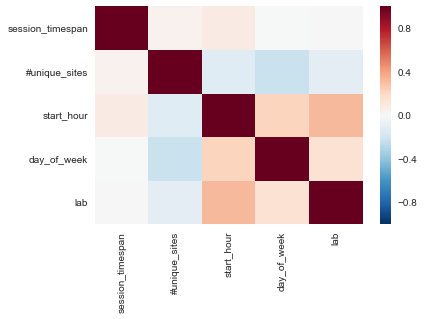

In [24]:
# построим heatmap для 4 рассматриваемых признаков
hm = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'lab']].corr()
sns.heatmap(hm)

**Признаки для начала сессии сильно всего коллерированы с нашей основной меткой, а вот у длины сессии совсем никакой корелляции, ее стоит выкинуть из рассмотрения**

## <right> Мы решаем задачу идентификации одного пользователя из множества поэтому попробуем отделить одного из пользователей и так же взглянуть на heatmap и гистограммы

In [27]:
train_data_10users['new_lab'] = train_data_10users.lab.apply(lambda x: 1 if x==1 else 0)

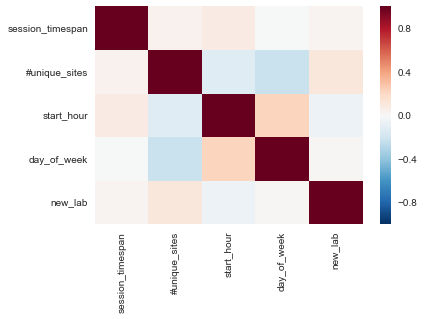

In [28]:
hm = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'new_lab']].corr()
sns.heatmap(hm)

Видно, что теперь ситуация меняется координально. Главным из 4 признаков становится количество уникальных сайтов в сессии. Визуализируем признаки start_hour и #unique_sites

In [10]:
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=a)
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'new_lab')): 
    trace = go.Histogram(x = sub_df['#unique_sites'], name=user)
    fig.append_trace(trace, int(idx/2)+1, int(idx%2)+1)
    
fig['layout'].update(title=u'Гистограмма признака: количество уникальных сайтов в сессии')
iplot(fig)

IndexError: list index out of range

In [ ]:
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=a)
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'new_lab')): 
    trace = go.Histogram(x = sub_df['start_hour'], name=user)
    fig.append_trace(trace, int(idx/2)+1, int(idx%2)+1)
    
fig['layout'].update(title=u'Гистограмма признака: час начала сессии')
iplot(fig)

**Гистограммы для количества уникальных сайтов существенно различаются. Графики для признака: час начала сессии, также имеют отличия, но не такие значительные**

**Проверим теорию, что для разных пользователей, ключевую роль играют разные призанки. Построим heatmap выделяя различных пользователей**

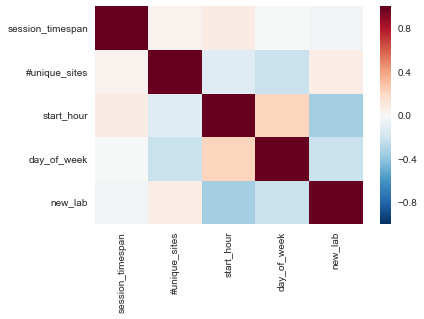

In [65]:
# пользователь номер 3
train_data_10users['new_lab'] = train_data_10users.lab.apply(lambda x: 1 if x==3 else 0)
hm = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'new_lab']].corr()
sns.heatmap(hm)

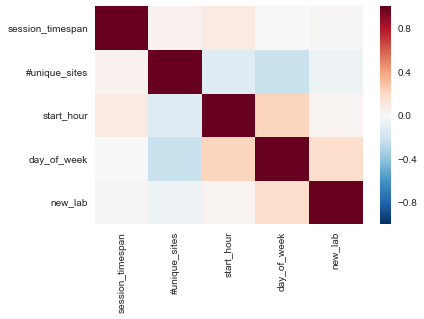

In [73]:
# пользователь номер 5
train_data_10users['new_lab'] = train_data_10users.lab.apply(lambda x: 1 if x==5 else 0)
hm = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'new_lab']].corr()
sns.heatmap(hm)

**Видно, что для каждого из пользователей разные признаки являются наиболее коррелированными, однако для всех практически отсутствует корреляция с временем сессии, выкинем ее из рассмотрения. Однако не стоит забывать, что признак, который не работает в одной задаче, может сработать в другой, например, длина сессии не важна при идентификации пользователя среди других простых пользователей, однако этот признак может быть полезен при идентификации взломщика или злоумышленника среди обычных пользователей**

**Составим еще несколько признаков, которые могут пригодиться в итоговой модели**

In [7]:
# напишем функцию для составления частотного словаря сайтов(ключ - id сайта, значение - частота)
#функция принимает на вход путь к сырым данным и словарю с id сайтов
def prepare_dict(path_to_csv_files, site_freq_path):
    a = glob(path_to_csv_files)
    b = openpickle(site_freq_path)
    slov = {}
    for file in enumerate(a):
        data1 = pd.read_csv(file[1])
        site_list = list(data1.site)
        for i, site in enumerate(site_list):
            id_site = b.get(site)
            if id_site in slov:
                slov[id_site] +=1
            else:
                slov[id_site] = 1
    return slov

In [7]:
freq_dict_10users = prepare_dict('10users/*.csv', 'site_dic.pkl')

In [8]:
# выделим 30 самых популярных 
top30_sites = []
for i in range(30):
    n = 0
    for k,v in freq_dict_10users.iteritems():
        if v > n:
            n = v
            n1 = k
    top30_sites.append(n1)
    freq_dict_10users.pop(n1)

In [4]:
# функция для построения двух признаков, частот посещения топ-30 популярных сайтов и месяца посещения
def feature_engineering(path_to_csv_files,site_dic_path, features, session_length=10, window_size=10):
    a = glob(path_to_csv_files)
    b = openpickle(site_dic_path)
    lines = []
    y = 0
    for file in enumerate(a):
        data1 = pd.read_csv(file[1])
        site_list = list(data1.site)
        time_list = list(pd.to_datetime(data1['timestamp']))
        y+=1
        for i in range(0,len(site_list),window_size):
            n_30 =0
            month = time_list[i].month
            line = []
            if (i+session_length) <= len(site_list): 
                for j in range(i, i+session_length):
                    id_site = b.get(site_list[j])
                    if id_site in  top30_sites:
                        n_30 +=1
            else:
                for j in range(i, len(site_list)):
                    id_site = b.get(site_list[j])
                    if id_site in  top30_sites:
                        n_30 +=1
            line.extend([month])
            line.extend([n_30])
            line.extend([y])
            lines.append(line)
    matrica = pd.DataFrame(lines, columns = feature_names)
    return matrica

In [9]:
feature_names = ['month','n_30', 'lab']
new_features_10users = feature_engineering('10users/*.csv','site_dic.pkl', features=feature_names)

In [10]:
new_features_10users.head()

,month,n_30,lab
0,11,2,1
1,11,0,1
2,11,2,1
3,11,0,1
4,11,1,1


In [12]:
fig = tools.make_subplots(rows=2, cols=5, subplot_titles=a)
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'lab')): 
    trace = go.Histogram(x = sub_df['month'], name=user)
    fig.append_trace(trace, int(idx/5)+1, int(idx%5)+1)
    
fig['layout'].update(title=u'Гистограмма признака: Месяц начала сессии')
iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]    [ (1,4) x4,y4 ]    [ (1,5) x5,y5 ]  
[ (2,1) x6,y6 ]    [ (2,2) x7,y7 ]    [ (2,3) x8,y8 ]    [ (2,4) x9,y9 ]    [ (2,5) x10,y10 ]



In [15]:
fig = tools.make_subplots(rows=2, cols=5, subplot_titles=a)
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'lab')): 
    trace = go.Histogram(x = sub_df['n_30'], name=user)
    fig.append_trace(trace, int(idx/5)+1, int(idx%5)+1)
    
fig['layout'].update(title=u'Гистограмма признака: количество популярных сайтов в сессии')
iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]    [ (1,4) x4,y4 ]    [ (1,5) x5,y5 ]  
[ (2,1) x6,y6 ]    [ (2,2) x7,y7 ]    [ (2,3) x8,y8 ]    [ (2,4) x9,y9 ]    [ (2,5) x10,y10 ]



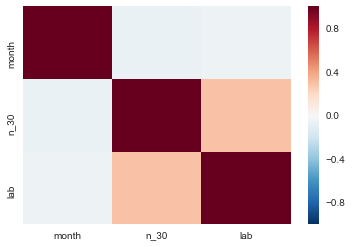

In [12]:
# heatmap по всем пользователям
hm = new_features_10users.corr()
sns.heatmap(hm)

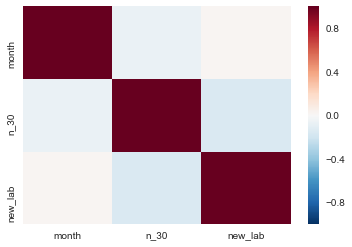

In [17]:
# heatmap по одному пользователю
new_features_10users['new_lab'] = new_features_10users.lab.apply(lambda x: 1 if x==1 else 0)
hm = new_features_10users[['month', 'n_30', 'new_lab']].corr()
sns.heatmap(hm)

**Из графиков видно, что только признак - количество популярных сайтов в сессии можно использовать в модели**

## <right> Мы разобрались с признаками, теперь перейдем к оценке моделей. Будем тестировать на реальных данных, на первом и втором варианте датасетов

 Оценивать модели будем по метрике - площадь под roc-auc кривой. Где по оси x отложен False Positive Rate  - сколько неправильно предсказанных 0 из всего количества 0 в выборке, а по оси y отложен True Positive Rate - сколько правильно предсказанных 1, среди всего объема 1

In [3]:
# считываем данные
train_df = pd.read_csv( 'train_sessions.csv',index_col='session_id')
test_df = pd.read_csv( 'test_sessions.csv',index_col='session_id')

In [4]:
# объединяем обучение и тест, чтобы составить признаки
train_test_df = pd.concat([train_df, test_df])
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')
train_test_time1 = list(pd.to_datetime(train_test_df['time1']))
y = train_df.target

In [6]:
train_test_df_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178


In [7]:
train_test_df_sites.shape

(336358, 10)

Функция для создания первого датасета - признаки, час, день недели начала сессии, количество уникальных сайтов и количество сайтов из топ-30

In [8]:
# выделим 30 популярных сайтов из всех данных
freq_dict_all = prepare_dict('400users/*.csv', 'site_dic.pkl')
top30_sites = []
for i in range(30):
    n = 0
    for k,v in freq_dict_all.iteritems():
        if v > n:
            n = v
            n1 = k
    top30_sites.append(n1)
    freq_dict_all.pop(n1)

In [ ]:
# составим выборку
def feature_engineering_all(data):
    feature_names = ['unique', 'hour', 'weekday', 'n_30']
    sid = []
    lines = []
    sd = 0
    for i, line in enumerate(data):  # для каждой сессии
        n_30=0                       # считаем количество сайтов из топ30        
        a = []                        
        sd+=1                       # id_site, дожен начинаться с 1, а не как обычно в DataFrame с 0.
        for _, el in enumerate(line):
            if el!= 0:               # 0 это пропуски сайтов - Nan, поэтому их не учитываем при подсчете уникальных сайтов в сессии
                a.append(el)
            if el in top30_sites:
                n_30+=1
        feat = [len(np.unique(a)), train_test_time1[i].hour, train_test_time1[i].weekday(), n_30] 
        sid.append(sd)
        lines.append(feat)
    return pd.DataFrame(lines, columns = feature_names, index=sid)

In [23]:
train_test_df_dop = feature_engineering_all(np.array(train_test_df_sites))

In [20]:
train_test_df_dop.head()

,unique,hour,weekday,n_30
1,1,10,3,0
2,7,11,5,2
3,4,16,0,3
4,1,10,4,10
5,4,10,4,1


In [24]:
train_test_df_sites['unique'] = train_test_df_dop.unique
train_test_df_sites['hour']  = train_test_df_dop.hour
train_test_df_sites['weekday'] = train_test_df_dop.weekday
train_test_df_sites['n_30'] = train_test_df_dop.n_30

In [25]:
train_test_df_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,unique,hour,weekday,n_30
session_id,,,,,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0,1,10,3,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518,7,11,5,2
3,14769,39,14768,14769,37,39,14768,14768,14768,14768,4,16,0,3
4,782,782,782,782,782,782,782,782,782,782,1,10,4,10
5,22,177,175,178,177,178,175,177,177,178,4,10,4,1


**Создадим второй датасет - csr матрица**

In [9]:
row = []
col = []
data = []
n_r = 0
# считываем сайты
sessions = np.array(train_test_df_sites[['site%d' % i for i in range(1, 11)]])
# для каждой сессии создаем частотный словарь
for session in sessions:
    small_voc = {}
    for id_site in session:
        if id_site != 0:
            id_site = id_site-1
            if id_site in small_voc:
                small_voc[id_site] += 1
            else:
                small_voc[id_site] = 1
    # заносим данные в списки
    for k,v in small_voc.iteritems():
        data.append(int(v))
        col.append(int(k))
        row.append(n_r)
    n_r += 1
# создаем матрицу
matrica = csr_matrix((data, (row,col)))

In [24]:
matrica.shape

(336358, 48371)

In [25]:
# раздели выборку на обучение и тест, как было изначально
X_train_sparse = matrica[0:len(train_df)]
X_test_sparse = matrica[len(train_df):len(train_df)+len(test_df)]
X_train = train_test_df_sites[0:len(train_df)]
X_test =train_test_df_sites[len(train_df):len(train_df)+len(test_df)]

In [28]:
# проверим с помощью cross_val_score улучшают ли доп признаки модель
sgd = SGDClassifier(random_state=17, loss='log')
a = cross_val_score(sgd, X_train.iloc[:,0:10], y, scoring='roc_auc').mean()
print(0, 'priznakov. roc_auc:', a)
for i in range(4):
    a = cross_val_score(sgd, X_train.iloc[:,0:11+i], y, scoring='roc_auc').mean()
    print(i+1, 'priznak. roc_auc:', a)

0 priznakov. roc_auc: 0.504156461651
1 priznak. roc_auc: 0.505439326866
2 priznak. roc_auc: 0.505570203609
3 priznak. roc_auc: 0.50471334637
4 priznak. roc_auc: 0.506832850705


**Улучшения есть, но незначительные**

**Посмотрим, что выдает классификатор на csr матрице**

In [246]:
a = cross_val_score(sgd, X_train_sparse, y,scoring='roc_auc').mean()
print('csr matrix. roc_auc score:', round(a,3))

csr matrix. roc_auc score: 0.938


**Большой прогресс. Попробуем добавить наши доп. признаки к csr матрице**

In [12]:
row = []
col = []
data = []
n_r = 0
# считываем сайты
sessions = np.array(train_test_df_sites[['site%d' % i for i in range(1, 11)]])
# для каждой сессии создаем частотный словарь
for i, session in enumerate(sessions):
    small_voc = {}
    n_30 = 0
    for _, id_site in enumerate(session):
        if id_site != 0:
            id_site = id_site-1
            if id_site in small_voc:
                small_voc[id_site] += 1
            else:
                small_voc[id_site] = 1
            if id_site in top30_sites:
                n_30+=1
    # заносим данные в списки
    for k,v in small_voc.iteritems():
        data.append(int(v))
        col.append(int(k))
        row.append(n_r)
    feat = [len(small_voc), train_test_time1[i].hour, train_test_time1[i].weekday(), n_30] 
    data.extend(feat)
    col.extend([48371, 48372, 48373, 48374])
    row.extend([n_r,n_r,n_r,n_r])
    n_r += 1
# создаем матрицу
matrica_4dop= csr_matrix((data, (row,col)))

In [13]:
matrica_4dop.shape

(336358, 48375)

In [63]:
X_train_sparse_4dop = matrica_4dop[0:len(train_df)]
X_test_sparse_4dop = matrica_4dop[len(train_df):len(train_df)+len(test_df)]
a = cross_val_score(sgd, X_train_sparse_4dop, y,scoring='roc_auc').mean()
print('csr matrix_4dop. roc_auc score:', round(a,3))

csr matrix_4dop. roc_auc score: 0.944


**Дополнительные признаки немного улучшили модель**

**Посмотрим на результаты кросс-валидации логистической регрессии и линейного SVM**

In [30]:
logr = LogisticRegression(C=3.0, random_state=17, n_jobs=-1)
svm = LinearSVC(C=1.0, random_state=17)

In [38]:
a = cross_val_score(logr, X_train_sparse, y , scoring='roc_auc').mean()
print('csr matrix log regression. roc_auc score: {}'.format(round(a,3)))

csr matrix log regression. roc_auc score: 0.961


In [152]:
a = cross_val_score(logr, X_train_sparse_4dop, y , scoring='roc_auc').mean()
print('csr matrix_4dop log regression. roc_auc score : {}'.format(round(a,3)))

csr matrix_4dop log regression. roc_auc score : 0.973


In [47]:
a = cross_val_score(svm, X_train_sparse, y , scoring='roc_auc').mean()
print('csr matrix linear svm. roc_auc score: {}'.format(round(a,3)))

csr matrix linear svm. roc_auc score: 0.947


In [31]:
a = cross_val_score(svm, X_train_sparse_4dop, y , scoring='roc_auc').mean()
print('csr matrix_4dop linear svm. roc_auc score: {}'.format(round(a,3)))

csr matrix_4dop linear svm. roc_auc score: 0.965


**Видим, что наши дополнительные признаки чуть-чуть улучшают модели логистической регрессии и линейного SVM. Попробуем настроить параметр С логистической регрессии**

**Сначала попробуем подобрать параметр С в широком диапазоне от 1е-4 до 1е+2** 

In [122]:
skf = StratifiedKFold(n_splits=3, shuffle=False, random_state=17)

In [58]:
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(n_jobs=-1, cv=skf, multi_class='multinomial', Cs=logit_c_values1,scoring='roc_auc') 
logit_grid_searcher1.fit(X_train_sparse_4dop, y)

LogisticRegressionCV(Cs=array([  1.00000e-04,   4.64159e-04,   2.15443e-03,   1.00000e-02,
         4.64159e-02,   2.15443e-01,   1.00000e+00,   4.64159e+00,
         2.15443e+01,   1.00000e+02]),
           class_weight=None,
           cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='multinomial', n_jobs=-1,
           penalty='l2', random_state=None, refit=True, scoring='roc_auc',
           solver='lbfgs', tol=0.0001, verbose=0)

In [59]:
logit_mean_cv_scores1 =[]
for j in range(10):
    a = 0
    for ar in logit_grid_searcher1.scores_.get(1):
        a = a+ar[j]
    logit_mean_cv_scores1.append(a/3)

In [61]:
logit_mean_cv_scores1

[0.84768022068991622,
 0.87115340233179273,
 0.9082603319855429,
 0.93769309898718778,
 0.95799453432462089,
 0.9685931730249554,
 0.97198697569451198,
 0.97284471151375795,
 0.97244115664966324,
 0.97236739564347019]

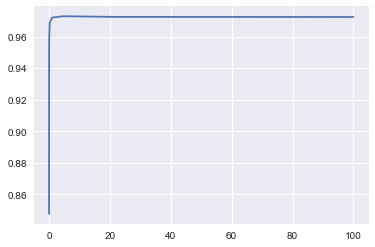

In [60]:
pylab.plot(logit_grid_searcher1.Cs_, logit_mean_cv_scores1)

**По графику видно, что максимум находиться где-то между 1 и 20. Сделаем более точный поиск в этом диапазоне**

In [66]:
logit_c_values1 = np.linspace(3, 7, 20)

logit_grid_searcher1 = LogisticRegressionCV(n_jobs=-1, cv=skf, multi_class='multinomial', Cs=logit_c_values1,scoring='roc_auc')
logit_grid_searcher1.fit(X_train_sparse_4dop, y)

LogisticRegressionCV(Cs=array([ 3.     ,  3.21053,  3.42105,  3.63158,  3.84211,  4.05263,
        4.26316,  4.47368,  4.68421,  4.89474,  5.10526,  5.31579,
        5.52632,  5.73684,  5.94737,  6.15789,  6.36842,  6.57895,
        6.78947,  7.     ]),
           class_weight=None,
           cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='multinomial', n_jobs=-1,
           penalty='l2', random_state=None, refit=True, scoring='roc_auc',
           solver='lbfgs', tol=0.0001, verbose=0)

In [70]:
logit_mean_cv_scores1 =[]
for j in range(20):
    a = 0
    for ar in logit_grid_searcher1.scores_.get(1):
        a = a+ar[j]
    logit_mean_cv_scores1.append(a/3)

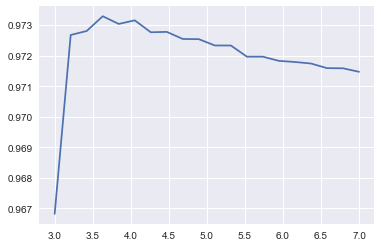

In [72]:
pylab.plot(logit_grid_searcher1.Cs_, logit_mean_cv_scores1)

In [78]:
logit_grid_searcher1.Cs_

array([ 3.        ,  3.21052632,  3.42105263,  3.63157895,  3.84210526,
        4.05263158,  4.26315789,  4.47368421,  4.68421053,  4.89473684,
        5.10526316,  5.31578947,  5.52631579,  5.73684211,  5.94736842,
        6.15789474,  6.36842105,  6.57894737,  6.78947368,  7.        ])

**Лучший С = 3.632**

**Попробуем теперь нелинейные алгоритмы, такие как градиентный бустинг и случайный лес. Поскольку для них долго проводить кросс-валидацию применим точечную оценку**

In [64]:
# разделяем обучающую выборку 70 на 30 по времени
train_share = int(.7 * X_train_sparse_4dop.shape[0])
X4_train, y4_train = X_train_sparse_4dop[:train_share, :], y[:train_share]
X4_valid, y4_valid  = X_train_sparse_4dop[train_share:, :], y[train_share:]

In [100]:
# создаем классификаторы. Для случайного леса попробуем разные критерии
rf1 = RandomForestClassifier(n_jobs=-1, criterion='gini')
rf2 = RandomForestClassifier(n_jobs=-1, criterion='entropy')
xgb = XGBClassifier(nthread=-1)

In [103]:
rf1.fit(X4_train, y4_train)
a = metrics.roc_auc_score(y4_valid,rf1.predict_proba(X4_valid)[:,1])
print(u'Случайный лес (Джини): точечная оценка roc_auc {}'.format(round(a,3)))

Случайный лес: точечная оценка roc_auc 0.91


In [104]:
rf2.fit(X4_train, y4_train)
a = metrics.roc_auc_score(y4_valid,rf2.predict_proba(X4_valid)[:,1])
print(u'Случайный лес (энтрпоия): точечная оценка roc_auc {}'.format(round(a,3)))

Случайный лес: точечная оценка roc_auc 0.901


In [105]:
xgb.fit(X4_train, y4_train)
a = metrics.roc_auc_score(y4_valid,xgb.predict_proba(X4_valid)[:,1])
print(u'Градиентный бустинг: точечная оценка roc_auc {}'.format(round(a,3)))

Градиентный бустинг: точечная оценка roc_auc 0.968


**У градиентного бустинга результаты похожи на результаты лог регрессии, случайный лес проигрывает**

**Итак мы выбрали 3 классификатора LogisticRegression, SGD и XGB попробуем настроить их с помощью GridSearch, затем построим для них learning curve**

In [68]:
# функция украдена из документации sklearn
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [17]:
# функция для записи ответов в csv файл
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

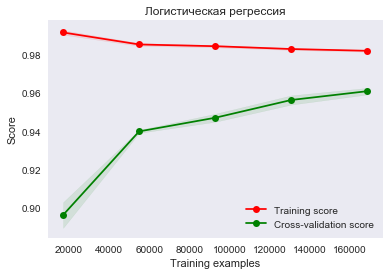

In [72]:
lr = LogisticRegression(C=3.632, random_state=17)
plot_learning_curve(lr,title= u'Логистическая регрессия', X=X_train_sparse_4dop, y=y, cv=skf)
lr.fit(X_train_sparse_4dop, y)
preds = lr.predict_proba(X_test_sparse_4dop)[:,1]
write_to_submission_file(preds, 'otvety_logr.csv')

In [191]:
sgd = SGDClassifier( n_jobs=-1)
params = {
    'random_state':[1,10,17,50],
    'loss': ['log', 'modified_huber'],
    'alpha': [0.0001, 0.001, 0.00001],
    'l1_ratio': [0.15, 0.2, 0.1],
    'max_iter': [5,7,10,20],
    'class_weight': [None, 'balanced']
}
grid1 = GridSearchCV(sgd,  scoring='roc_auc', param_grid=params, cv=skf, n_jobs=-1)
grid1.fit(X_train_sparse_4dop, y)
print(grid1.best_params_, grid1.best_score_)

{'loss': 'modified_huber', 'l1_ratio': 0.15, 'max_iter': 20, 'random_state': 17, 'alpha': 0.001, 'class_weight': 'balanced'} 0.965272439415


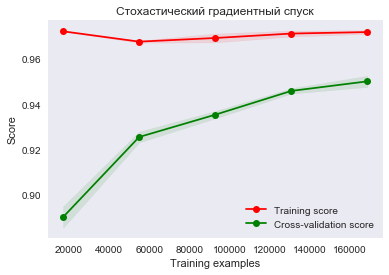

In [69]:
# занесем лучшие параметры поиска по сетке в нашу конечную модель, обучим и запишем ее предсказания
sgd = SGDClassifier(loss='modified_huber',n_jobs=-1, l1_ratio=0.15, max_iter=20, random_state=17, alpha=0.001, class_weight='balanced')
plot_learning_curve(sgd,title= u'Стохастический градиентный спуск', X=X_train_sparse_4dop, y=y, cv=skf)
sgd.fit(X_train_sparse_4dop, y)
preds = sgd.predict_proba(X_test_sparse_4dop)[:,1]
write_to_submission_file(preds, 'otvety_sgd.csv')

In [193]:
xgb = XGBClassifier(nthread=-1 ) 
params = {
    'max_depth': [3,5],
    'scale_pos_weight': [1, 0.01, 0.001],
    'n_estimators': [100,200]
}
grid1 = GridSearchCV(xgb,  scoring='roc_auc', param_grid=params, cv=skf, n_jobs=-1)
grid1.fit(X_train_sparse_4dop, y)
print(grid1.best_params_, grid1.best_score_)

{'n_estimators': 200, 'scale_pos_weight': 1, 'max_depth': 5} 0.985413109404


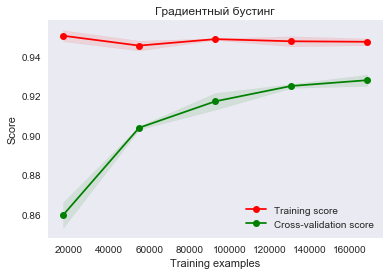

In [71]:
xgb = XGBClassifier(nthread=-1, max_depth=5, scale_pos_weight=1, n_estimators=200)
plot_learning_curve(xgb,title= u'Градиентный бустинг', X=X_train_sparse_4dop, y=y, cv=skf)
xgb.fit(X_train_sparse_4dop, y)
preds = xgb.predict_proba(X_test_sparse_4dop)[:,1]
write_to_submission_file(preds, 'otvety_xgb.csv')

**По кривым видно, что лучшим из 3х алогритмов является логистическая регрессия и большое количество объектов для каждого из алгоритмов приводит к лучшему результату**

**Попробуем два подхода, которые объединяют разные алгоритмы в один большой. Первый это ансамбль, где берется среднее предсказание по всем алгоритмам, второй - стекинг, подробнее https://alexanderdyakonov.wordpress.com/2017/03/10/cтекинг-stacking-и-блендинг-blending/**

**Поскольку стекинг и ансамбль выполняются очень долго будем сразу обучать на всей обучающей и проверять результат уже на кегл**

**Для ансамбля берем непохожие алгоритмы, которые могут исправлять ошибки друг друга**

In [107]:
# создаем 4 классификатора
lr = LogisticRegression(random_state=17, C=3.632)
sgd = SGDClassifier(random_state=17, loss='log')
rf2 = RandomForestClassifier(n_jobs=-1, criterion='entropy')
et = ExtraTreesClassifier(n_jobs=-1)

In [108]:
# обучим каждый по очереди
lr.fit(X_train_sparse_4dop,y)
pre1 = np.array(lr.predict_proba(X_test_sparse_4dop)[:,1])

In [109]:
sgd.fit(X_train_sparse_4dop,y)
pre2 = np.array(sgd.predict_proba(X_test_sparse_4dop)[:,1])

In [110]:
et.fit(X_train_sparse_4dop,y)
pre3 = np.array(et.predict_proba(X_test_sparse_4dop)[:,1])

In [111]:
rf2.fit(X_train_sparse_4dop,y)
pre4 = np.array(rf2.predict_proba(X_test_sparse_4dop)[:,1])

In [112]:
# получим финальные предсказания
predictions = np.array([pre1,pre2,pre3,pre4])

In [117]:
preda = predictions.mean(axis=0)

In [202]:
for i in range(len(preda)):
    if preda[i]>0.8:
        preda[i]=1

In [203]:
write_to_submission_file(preda, 'otvety_ensemble.csv')

** Теперь попробуем стекинг**

In [62]:
# кросс-валидация без смешивания
y = np.array(y)
skf =StratifiedKFold(n_splits=3, shuffle=False, random_state=1)

In [180]:
# 5 классификаторов будут создавать метапризнаки, конечным алгоритмом станет логистическая регрессия
clf1 = RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='gini')
clf2 = RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='entropy')
clf3 = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='gini')
clf4 = SGDClassifier(loss='log')
clf5 = XGBClassifier(learning_rate=0.05, n_estimators=100)
itog_clf = LogisticRegression(random_state=1)

In [178]:
clfs = [clf1,clf2,clf3,clf4,clf5]
features_train = np.zeros((X_train_sparse_4dop.shape[0],5))
features_test = np.zeros((X_test_sparse_4dop.shape[0],5))
for i,classifier in enumerate(clfs):            # обучаем каждый из классификаторов на кросс-валидации
    feat_tr = []
    feat_te = np.zeros((X_test_sparse_4dop.shape[0], 3))
    for j , (train, test) in enumerate(skf.split(X_train_sparse_4dop, y)): # на каждом этапе кросс-валидации
        print(classifier,j)
        classifier.fit(X_train_sparse_4dop[train], y[train])                    # обучаем классификатор      
        feat_tr.extend(classifier.predict_proba(X_train_sparse_4dop[test])[:,1])# записываем предсказания на тесте кросс-валидации, как мета-признаки
        feat_te[:,j] = classifier.predict_proba(X_test_sparse_4dop)[:,1]        # предсказываем значения на тесте
    features_train[:,i] = feat_tr                  # новый признак для обучения состоит из предсказания для всех объектов обучения
    features_test[:,i] = np.mean(feat_te, axis=1)  # новый признак для теста - усреднение предсказаний на кросс-валидации

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 0
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 1
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
    

In [181]:
itog_clf.fit(features_train,y)
pred = itog_clf.predict_proba(features_test)[:,1]
write_to_submission_file(pred, 'otvety_stacking.csv')

**Последним из испробованных алгоритмов будет градиентный спуск в Vowpal Wabbit**

**Напишем функцию для преобразования данных в формат, с которым работает vowpal wabbit**

In [141]:
def arrays_to_vw(X, y=None, train=True, out_file='tmp.vw'):
    lines = []
    if train == True:
        for i,el in enumerate(X):
            line = str(y[i])+' | '
            for j, st in enumerate(el):
                line = line + str(st)+' '
            lines.append(line+'\n')
    if train == False:
        for i,el in enumerate(X):
            line = str(1)+' | '
            for j, st in enumerate(el):
                line = line + str(st)+' '
            lines.append(line+'\n')
    with open(out_file, 'w') as vw_train_data:
        for _, line in enumerate(lines):
            vw_train_data.write(line)

In [182]:
# при указывании логистической функции потерь ответы должны быть 1 и -1
y_for_vw1 = np.array(train_df.target)
y_for_vw2 = []
for _, el in enumerate(y_for_vw1):
    if el == 0:
        y_for_vw2.append(-1)
    else:
        y_for_vw2.append(1)

In [262]:
arrays_to_vw(np.array(X_train), y_for_vw2, out_file='super_train_4dop.vw')
arrays_to_vw(np.array(X_test), train=False, out_file='super_test_4dop.vw')

In [263]:
# обучение модели
!vw -d super_train_3dop.vw --passes 7 --loss_function logistic -c -k -b 26 -f super_model.vw --quiet

In [264]:
# предсказания на тесте
!vw -i super_model.vw -t -d super_test_3dop.vw --loss_function=logistic --link=logistic -p super_pred.csv --quiet

In [265]:
# здесь записываем предсказания
a = pd.read_csv('super_pred.csv', header=None)
b = np.array(1-a)
write_to_submission_file(b, 'otvety_vw.csv')

# <center> Результаты kaggle

### <right> Логистическая регрессия - 0.91432
### <right> SGD классификатор - 0.83446(произошло переобучение). Лучшая попытка с другими параметрами loss ='log', random_state=17 - 0.90282
### <right> Градиентный бустинг - 0.90817
### <right> Ансамбль - 0.93436
### <right> Стекинг - 0.92268
### <right> Vowpal Wabbit - 0.49155 с 4 дополнительными признаками и 0.92393 c 3 дополнительными признаками(без признака - количество популярных сайтов в сессии)